<a href="https://colab.research.google.com/github/andersonhbent/volleyball-gymnastics/blob/main/V%C3%B4lei_ou_Gin%C3%A1stica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Montando Dataset de Imagens**

O dataset foi montado a partir da busca de imagens no Bing, através da biblioteca "bing-image-downloader". Na seção abaixo está o código que foi utilizado. Mas ele vai ficar com como texto, para não rodar nada e perdermos tempo, já que o dataset foi subido no github e clonado no início do script

In [1]:
!git clone https://github.com/andersonhbent/volleyball-gymnastics

Cloning into 'volleyball-gymnastics'...
remote: Enumerating objects: 359, done.
remote: Counting objects: 100% (359/359), done.
remote: Compressing objects: 100% (357/357), done.
remote: Total 359 (delta 1), reused 354 (delta 0), pack-reused 0
Receiving objects: 100% (359/359), 102.63 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (1001/1001), done.


In [2]:
#!pip install bing-image-downloader
!pip install split-folders

from bing_image_downloader import downloader

def get_images(query):
    """Download images and place them in a directory.
    
    :param query: Query to search for
    :return: Images matching query
    
    """
    print(query)
    
    downloader.download(query, 
                    limit=500, 
                    output_dir='olympic_sports', 
                    adult_filter_off=False, 
                    force_replace=False, 
                    timeout=30)

O código abaixo monta o dataset e sua execução dura pouco menos de 5 minutos.

In [24]:
#modalidades = ['volleyball', 'Gymnastics']

#for modalidade in modalidades:
#    print('Fetching images of', modalidade)
#    get_images(modalidade)

Para montar o dataset, foram utilizadas as 500 primeiras respostas do bing imagens para cada termo pesquisado, "Volleyball" e "Gymnastics". Daqui podemos tirar dois aprendizados: (1) as respostas pra buscas com o termo em inglês tiveram resultados superiores do que quando pesquisados em portugês. Além disso, a capacidade de uma imagem em individual representar o termo tende a cair quanto mais fotos são requisitadas. Acima, foram 500 para cada classe. As imagens depois da busca de número 450 tendem a ter mais erros. Por ex: exibir medalhas, outras modalidades ou até mesmo uma modelo usando um collant (pra o caso de ginástica), ou apenas atletas das modalidades comparecendo a eventos. Mas em geral foram buscas muito mais precisas do que a primeira tentativa do projeto, onde buscava separar vôlei de quadra e de praia.

In [4]:
import splitfolders
splitfolders.ratio('/content/volleyball-gymnastics/olympic', output="data", seed=1337, ratio=(0.5, 0.5)) 


Copying files: 1000 files [00:00, 1239.97 files/s]


O método "splitfolders" foi um achado interessante durante o projeto. Ele transforma um conjuntos de duas subpastas - uma pra cada classe - no exato formato de entrada da rede neural.

## **Importando Pacotes do Pytorch**

In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

### **Preparando os dados para serem trabalhados com Pytorch**




In [6]:
# Make transforms and use data loaders

# We'll use these a lot, so make them variables
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]), 'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
]),
}

In [7]:
# Set the directory for the data
data_dir = 'data/'

# Use the image folder function to create datasets
chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), chosen_transforms[x]) for x in ['train', 'val']}

In [8]:
chosen_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 500
     Root location: data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 500
     Root location: data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [9]:
# Make iterables with the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=4,
  shuffle=True, num_workers=4)
              for x in ['train', 'val']}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fcc36fcdbd0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fcc36fcdcd0>}

In [11]:
dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'val']}
class_names = chosen_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
print(dataset_sizes)
print(class_names)

{'train': 500, 'val': 500}
['gymnastics', 'volleyball']


Visualizando algumas imagens do dataset

In [13]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


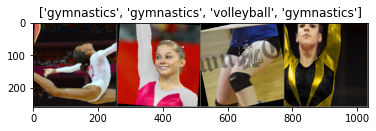

In [14]:
# Grab some of the training data to visualize
inputs, classes = next(iter(dataloaders['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## **Carregando o modelo pré-treinado**


In [15]:
# Setting up the model
# load in pretrained and reset final fully connected

res_mod = models.resnet34(pretrained=True)

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

# **Treinando o Modelo**


In [16]:
res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(res_mod.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

## Obsevando resultados do Modelo


In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/19
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3397 Acc: 0.8380
Iterating through data...
val Loss: 0.1291 Acc: 0.9420

Epoch 1/19
----------
Iterating through data...
train Loss: 0.3330 Acc: 0.8520
Iterating through data...
val Loss: 0.1332 Acc: 0.9440

Epoch 2/19
----------
Iterating through data...
train Loss: 0.3055 Acc: 0.8580
Iterating through data...
val Loss: 0.1236 Acc: 0.9520

Epoch 3/19
----------
Iterating through data...
train Loss: 0.3100 Acc: 0.8780
Iterating through data...
val Loss: 0.1215 Acc: 0.9400

Epoch 4/19
----------
Iterating through data...
train Loss: 0.3034 Acc: 0.8540
Iterating through data...
val Loss: 0.1430 Acc: 0.9320

Epoch 5/19
----------
Iterating through data...
train Loss: 0.3017 Acc: 0.8680
Iterating through data...
val Loss: 0.1344 Acc: 0.9480

Epoch 6/19
----------
Iterating through data...
train Loss: 0.3134 Acc: 0.8580
Iterating through data...
val Loss: 0.1315 Acc: 0.9400

Epoch 7/19
----------
Iterating through data...
train Loss: 0.3265 Acc: 0.8440
Iterating through data..

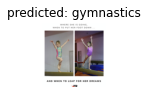

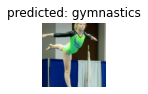

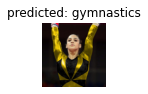

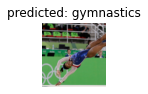

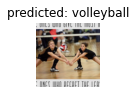

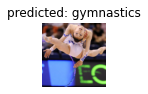

In [31]:
base_model = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)
visualize_model(base_model)
plt.show()

Depois de treinar o modelo com 3, 5 e 10 epocas, testei com 20. A variação entre o loss rate de treinamento e validação se manteve com leves instabilidades entre 4 e 10 épocas. Já com mais de 10, até 20, o modelo passa a ter uma taxa de acurácia um pouco maior, mas o loss rate passa a ter uma divergência maior entre treino e teste, indicando que o modelo pode estar ficando ajustado demais aos dados, overfitted. Por isso, voltei ao início e refiz o modelo com as 3 épocas iniciais, onde obteve mais de 95% de acurácia na validação e uma menor divergência entre o loss rate do treino e validação. Ainda sim, quando o modelo é rodado novas vezes, os resultados apresentam uma pesquena instabilidade na acurácia e loss rate, mesmo quando tem o mesmo número de épocas, talvez pelo tamanho da amostra, apenas com 250 imagens de cada classe para cada etapa. De toda forma, esse foi um modelo que com poucas imagens e de forma rápida obteve uma acurácia consistentemente maior que 94% em diversos cenários.

Epoch 0/3
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.3023 Acc: 0.8740
Iterating through data...
val Loss: 0.0947 Acc: 0.9660

Epoch 1/3
----------
Iterating through data...
train Loss: 0.3020 Acc: 0.8780
Iterating through data...
val Loss: 0.1092 Acc: 0.9640

Epoch 2/3
----------
Iterating through data...
train Loss: 0.3200 Acc: 0.8740
Iterating through data...
val Loss: 0.1105 Acc: 0.9600

Epoch 3/3
----------
Iterating through data...
train Loss: 0.3303 Acc: 0.8580
Iterating through data...
val Loss: 0.0990 Acc: 0.9680

Training complete in 2m 44s
Best val Acc: 0.968000


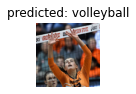

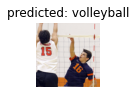

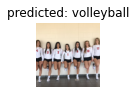

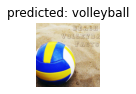

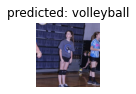

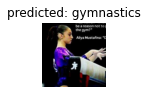

In [39]:
base_model = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=4)
visualize_model(base_model)
plt.show()


## Fixed Feature Extractor


In [32]:
# Setting up the model
# Note that the parameters of imported models are set to requires_grad=True by default

res_mod = models.resnet34(pretrained=True)
for param in res_mod.parameters():
    param.requires_grad = False

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 2)

res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss()

# Here's another change: instead of all parameters being optimized
# only the params of the final layers are being optimized

optimizer_ft = optim.SGD(res_mod.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [33]:
for name, child in res_mod.named_children():
    if name in ['layer3', 'layer4']:
        print(name + 'has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

layer3has been unfrozen.
layer4has been unfrozen.


In [34]:
optimizer_conv = torch.optim.SGD(filter(lambda x: x.requires_grad, res_mod.parameters()), lr=0.001, momentum=0.9)

Epoch 0/2
----------
Iterating through data...


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.4916 Acc: 0.7420
Iterating through data...
val Loss: 0.2165 Acc: 0.8980

Epoch 1/2
----------
Iterating through data...
train Loss: 0.3503 Acc: 0.8420
Iterating through data...
val Loss: 0.0963 Acc: 0.9620

Epoch 2/2
----------
Iterating through data...
train Loss: 0.2924 Acc: 0.8820
Iterating through data...
val Loss: 0.2012 Acc: 0.9300

Training complete in 2m 5s
Best val Acc: 0.962000


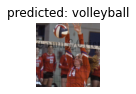

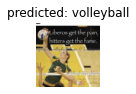

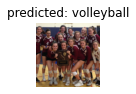

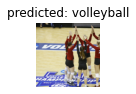

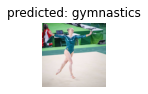

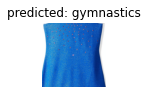

In [35]:
base_model = train_model(res_mod, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=3)
visualize_model(base_model)
plt.show()

In [36]:
torch.save(base_model.state_dict(), "/content/data/test.pt" )

In [37]:
base_model.load_state_dict(torch.load("/content/data/test.pt"))
base_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  